In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

np.random.seed(1)

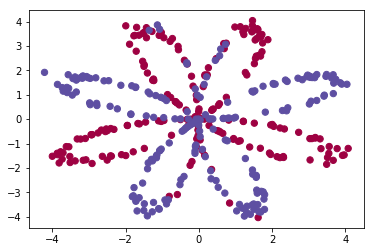

In [4]:
# 生成训练样本

m = 400  # 样本总数
N = int(m/2) # 每种样本数
a = 4 # 花瓣延伸的最大长度
X = np.zeros((m, 2)) # 初始化训练
Y = np.zeros((m, 1), dtype='uint8') # 初始化标签，0为红色，1为蓝色
    
for j in range(2): # 随机分配样本坐标，使样本组成一朵花形
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12, (j+1)*3.12,N) + np.random.randn(N)*0.2 # 角度
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # 半径
    X[ix] = np.c_[r*np.sin(t),r*np.cos(t)]
    Y[ix] = j

X = X.T
Y = Y.T
plt.scatter(X[0,:], X[1,:], c=Y[0, :], s=40, cmap=plt.cm.Spectral) 

In [7]:
# 决策边界

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0,:].min() - 1, X[0,:].max() + 1
    y_min, y_max = X[1,:].min() - 1, X[0,:].max() + 1
    h = 0.01
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0,:], X[1,:], c=y[0, :], cmap=plt.cm.Spectral)

使用logistic回归的分类精确度：47%


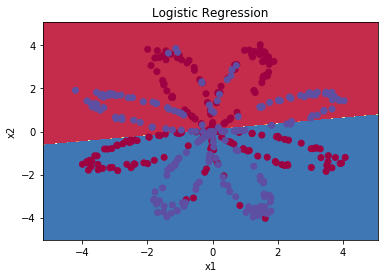

In [11]:
# 使用logistic回归进行分类

clf = sklearn.linear_model.LogisticRegressionCV(cv=3) # 初始化分类器
clf.fit(X.T,Y.T.ravel()) # 拟合

plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

LR_predictions = clf.predict(X.T)
print('使用logistic回归的分类精确度：%d' % float((np.dot(Y,LR_predictions) + np.dot(1-Y, 1-LR_predictions))/float(Y.size)*100) + "%")

In [18]:
# 用包含一个隐藏层的神经网络来分类

# 随机初始化
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    
    W1 = np.random.randn(n_h,n_x)*0.01 
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(1,n_h)*0.01 
    b2 = np.zeros((1,1))
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

In [19]:
# 正向传播

def sigmoid(x):
    s = 1/(1 + np.exp(-x))
    return s 

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1":Z1, "A1":A1, "Z2":Z2, "A2":A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters): # 成本
    m = Y.shape[1]
    
    cost = -np.sum(np.multiply(Y,np.log(A2)) + np.multiply((1-Y),np.log(1-A2)))/m
    cost = np.squeeze(cost)
    
    return cost  

In [20]:
#反向传播

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 -Y
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.dot(W2.T, dZ2)*(1 - np.power(A1,2))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    grads = {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2): # 更新参数
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
     
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [21]:
# 预测结果

def predict(parameters, X):
    A2, cache= forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [22]:
# 整个模型

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost = False): # n_h：隐藏层中的神经元个数
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    parameters = initialize_parameters(n_x, n_h, n_y);
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        
        if print_cost and i % 1000 == 0:
            print("循环%i次后的成本: %f" %(i, cost))

    return parameters

循环0次后的成本: 0.693048
循环1000次后的成本: 0.288083
循环2000次后的成本: 0.254385
循环3000次后的成本: 0.233864
循环4000次后的成本: 0.226792
循环5000次后的成本: 0.222644
循环6000次后的成本: 0.219731
循环7000次后的成本: 0.217504
循环8000次后的成本: 0.219472
循环9000次后的成本: 0.218562
准确度: 90%


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

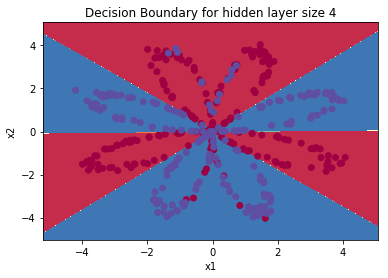

In [23]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

predictions = predict(parameters, X)
print ('准确度: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%') 

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

节点数为1时的分类准确度为 : 67.5 %
节点数为2时的分类准确度为 : 67.25 %
节点数为3时的分类准确度为 : 90.75 %
节点数为4时的分类准确度为 : 90.5 %
节点数为5时的分类准确度为 : 91.25 %
节点数为20时的分类准确度为 : 90.5 %
节点数为50时的分类准确度为 : 90.75 %
节点数为100时的分类准确度为 : 91.0 %


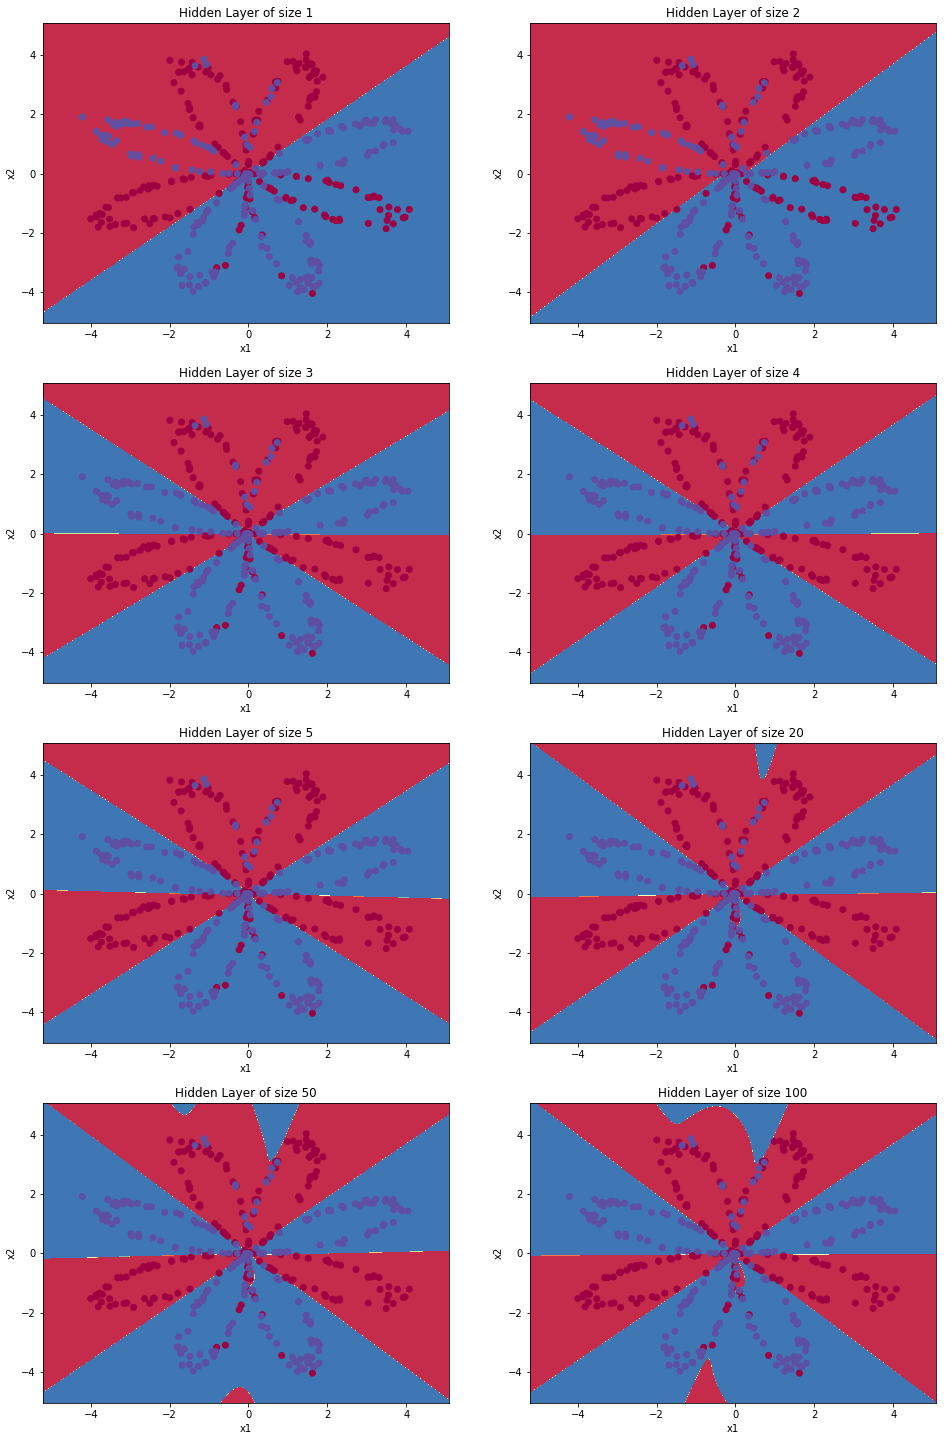

In [24]:
# 采用不同神经元数的分类效果

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50, 100]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("节点数为{}时的分类准确度为 : {} %".format(n_h, accuracy))